In [329]:
import numpy as np
import pandas as pd
from pandas_datareader import Options

import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import scipy.interpolate as interp
from multiprocessing import Pool
import sys
from IPython.display import clear_output
from sklearn.preprocessing import PolynomialFeatures
from copy import copy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run report/scripts/sampleendprice.py
%run report/scripts/pricecall.py
%run interpolated_local_vol.py

plt.rcParams['figure.figsize'] = (5,5/1.618)

In [145]:
class LocalVolatilityPricer:
    def __init__(self, local_vol, expiries, strikes):
        self.local_vol = local_vol
        self.expiries = expiries
        self.strikes = strikes
        
    def get_true_prices(self, S0=100, interval_per_year=100, n_samples=int(1e5)):
        self.S0 = S0
        true_prices = 0
        for _ in tqdm(range(100)):
            sample = sample_end_prices(self.S0, self.local_vol, self.expiries, 
                                   interval_per_year, n_samples)
            true_prices += price_calls(self.strikes, sample)
        self.true_prices = true_prices / 100
        return self.true_prices
    
    def fit_local_vol(self, fitter, interp_option='linear', *args, **kwargs):
        lvol, dCdT, d2CdK2 = fitter(self.true_prices, *args, **kwargs)
        self.fitted_local_vol = lvol
        self.dCdT = dCdT
        self.d2CdK2 = d2CdK2
        self._interpolate_local_vol(interp_option)
        return self.fitted_local_vol
    
    def _interpolate_local_vol(self, interp_option):
        if interp_option == 'linear':
            data = self.fitted_local_vol.T.stack().reset_index().as_matrix()
            stks, exps, lv = data[:,0], data[:,1], data[:,2]
            self.interp_fitted_local_vol = InterpolatedLocalVol(lv, stks, exps)
        elif interp_option == 'nn':
            data = self.fitted_local_vol.T.stack().reset_index().as_matrix()
            args, lv = data[:,:2], data[:,2]
            self.interp_fitted_local_vol = interp.NearestNDInterpolator(args, lv)
        else:
            raise ValueError
        
    def generate_prediction(self, interval_per_year=100, n_samples=int(1e5)):
        f_samples = sample_end_prices(self.S0, self.interp_fitted_local_vol,
                                      self.expiries, interval_per_year, n_samples)
        self.predicted_prices = price_calls(self.strikes, f_samples)
        return self.predicted_prices

    def plot_errors(self):
        f, ax = plt.subplots(nrows=2, figsize=(5, 2 * 5/1.618))
        sns.heatmap(self.predicted_prices - self.true_prices, ax=ax[0], fmt='%.2f')
        sns.heatmap(np.abs(self.predicted_prices - self.true_prices), ax=ax[1])
        
    def plot_fit(self, time, xs=np.arange(70,130,.1)):
        plt.plot(xs, self.local_vol(xs,time))
        plt.plot(xs, self.interp_fitted_local_vol(xs, time))
    

In [245]:
expiries = np.arange(1/12,13/12,1/12)
K = np.arange(50,151,1)

In [225]:
def fd_fitter(C_grid, tol=0.):
    dts = np.diff(C_grid.index)

    # Compute dCdt
    dCdt = np.clip((C_grid.as_matrix()[1:,:] 
                    - C_grid.as_matrix()[:-1,:]) 
                   / dts[:,np.newaxis], a_min=0, a_max=None)

    # Centered difference dcdt
    dCdt_compatible = (dCdt[1:,1:-1] + dCdt[:-1,1:-1]) / 2

    # Assume equal strikes
    Kdiff = np.diff(C_grid.columns)[0]
    d2CdK2 = (C_grid.as_matrix()[:,:-2] + C_grid.as_matrix()[:,2:] 
              - 2*C_grid.as_matrix()[:,1:-1]) / Kdiff**2
    d2CdK2_compatible = d2CdK2[1:-1,:]

    # set second derivative of < tol to np.nan
    d2CdK2_compatible[d2CdK2_compatible < tol] = np.nan

    new_expiries = C_grid.index[1:-1]
    new_strikes = np.array(C_grid.columns[1:-1])    

    local_vol2 = (dCdt_compatible / (1/2 * np.array(new_strikes ** 2).reshape(1,-1) * d2CdK2_compatible))

    return (pd.DataFrame(np.sqrt(local_vol2), index=new_expiries, columns=new_strikes),
            pd.DataFrame(dCdt_compatible, index=new_expiries, columns=new_strikes),
            pd.DataFrame(d2CdK2_compatible, index=new_expiries, columns=new_strikes))

def local_quadratic_reg_fit(pxs, tol=0):
    def compute_derivatives(coeffs, strike, expiry):
        return (coeffs[2] + coeffs[4] * strike + 2 * coeffs[5] * expiry,
                2 * coeffs[3])

    local_vol2 = np.zeros((len(pxs) - 2, len(pxs.columns) - 2))
    dCdTs = np.zeros((len(pxs) - 2, len(pxs.columns) - 2))
    d2CdK2s = np.zeros((len(pxs) - 2, len(pxs.columns) - 2))
    for i in range(1, len(pxs)-1):
        for j in range(1, len(pxs.columns)-1):
            local = pxs.iloc[i-1:i+2,j-1:j+2]
            strike = pxs.columns[j]
            expiry = pxs.index[i]
            strikes, expiries = np.meshgrid(local.columns, local.index)
            poly = PolynomialFeatures(degree=2)
            features = poly.fit_transform(np.vstack([strikes.flatten(), expiries.flatten()]).T)
            coeffs, _, _, _ = np.linalg.lstsq(features, local.as_matrix().flatten())
            dCdT, d2CdK2 = compute_derivatives(coeffs, strike, expiry)
            dCdT = np.clip(dCdT, a_min=0, a_max=None)
            d2CdK2 = d2CdK2 if d2CdK2 >= tol else np.nan
            local_vol2[i-1, j-1] = dCdT / (1/2 * (strike ** 2) * d2CdK2)
            dCdTs[i-1,j-1] = dCdT
            d2CdK2s[i-1,j-1] = d2CdK2
    local_vol = pd.DataFrame(np.sqrt(local_vol2), columns=pxs.columns[1:-1], index=pxs.index[1:-1])
    dCdTs = pd.DataFrame(dCdTs, columns=pxs.columns[1:-1], index=pxs.index[1:-1])
    d2CdK2s = pd.DataFrame(d2CdK2s, columns=pxs.columns[1:-1], index=pxs.index[1:-1])
    return local_vol, dCdTs, d2CdK2s

In [259]:
def quadratic_vol(px, time):
    return np.clip(.16 + 1e-4*(px-100)**2, 0, .5)

# Quadratic

In [205]:
qv = LocalVolatilityPricer(quadratic_vol, expiries, K)
_ = qv.get_true_prices(n_samples=int(1e5))
qv2 = copy(qv)

A Jupyter Widget

In [289]:
_ = qv.fit_local_vol(fd_fitter, interp_option='nn', tol=0.01)
_ = qv2.fit_local_vol(local_quadratic_reg_fit, interp_option='nn', tol=0.01)

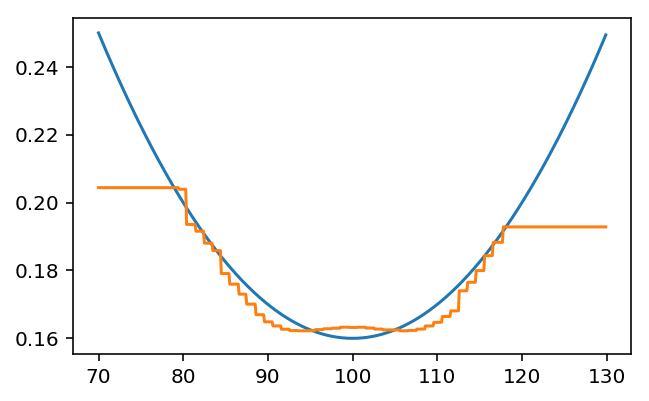

In [295]:
qv.plot_fit(0)

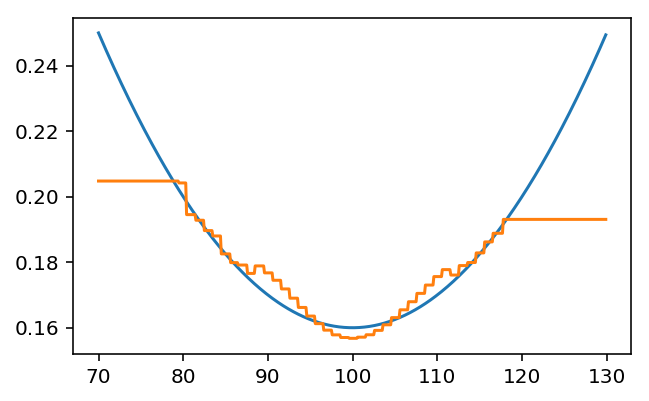

In [296]:
qv2.plot_fit(0)

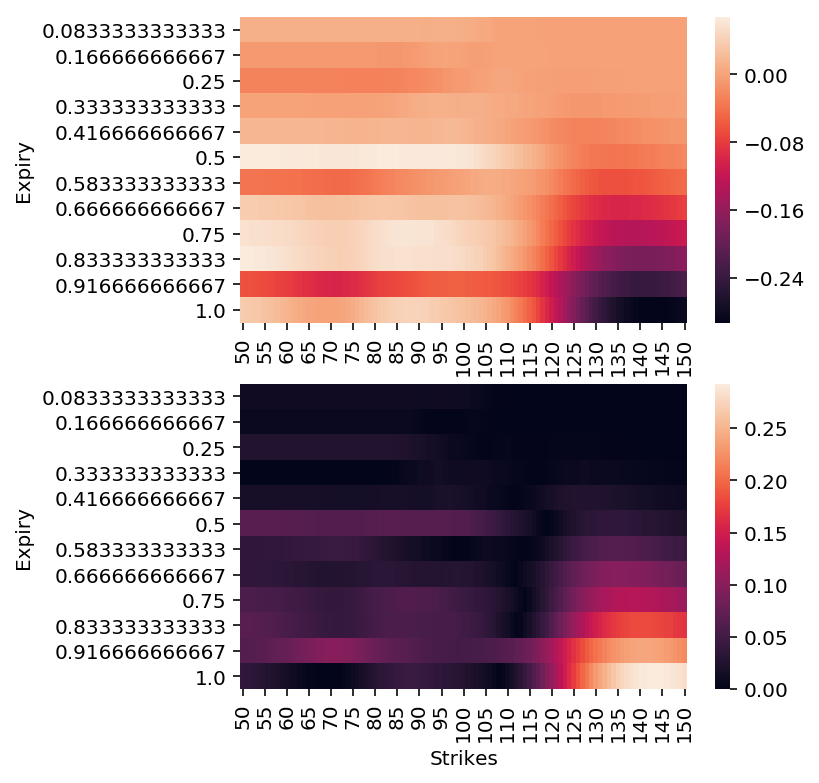

In [298]:
_ = qv.generate_prediction(n_samples=int(1e5))
qv.plot_errors()

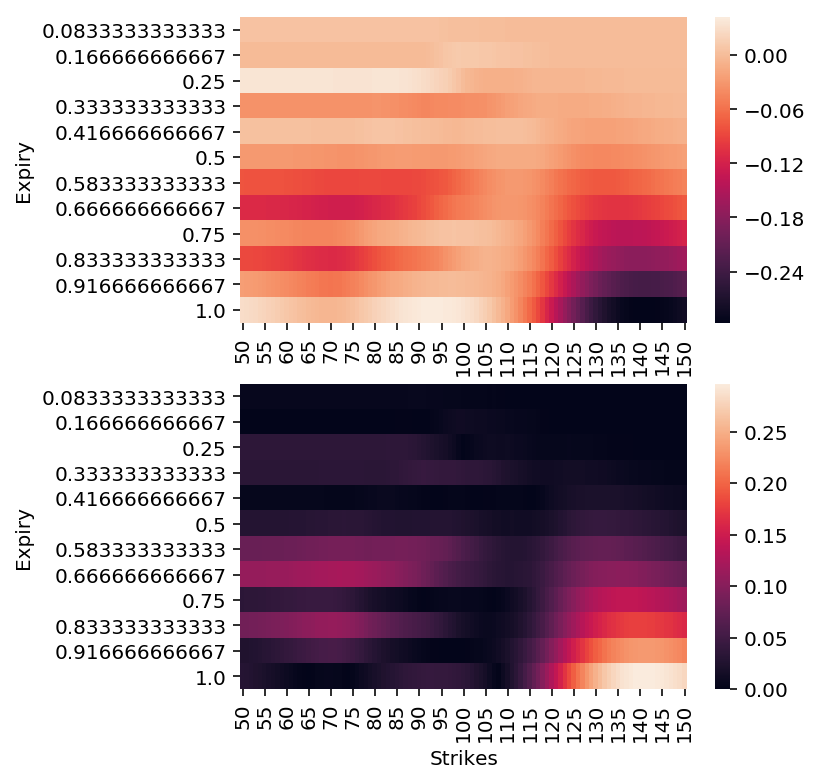

In [297]:
_ = qv2.generate_prediction(n_samples=int(1e5))
qv2.plot_errors()

# Sinusoidal

In [167]:
def sinusoidal_vol(px, time):
    return 0.2 * (np.cos((px-100)/10)) ** 2 + 0.16
sv = LocalVolatilityPricer(sinusoidal_vol, expiries, K)
_ = sv.get_true_prices(n_samples=int(1e5))

A Jupyter Widget

In [299]:
sv2 = copy(sv)

In [301]:
_ = sv.fit_local_vol(fd_fitter, interp_option='nn', tol=0.005).dropna(axis=1)
_ = sv2.fit_local_vol(local_quadratic_reg_fit, interp_option='nn', tol=0.005).dropna(axis=1)

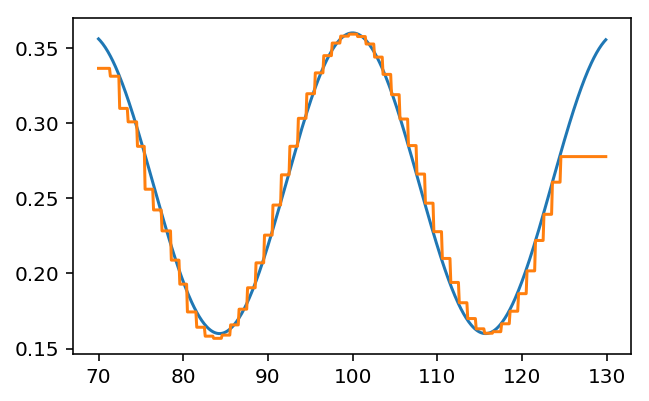

In [302]:
sv.plot_fit(0)

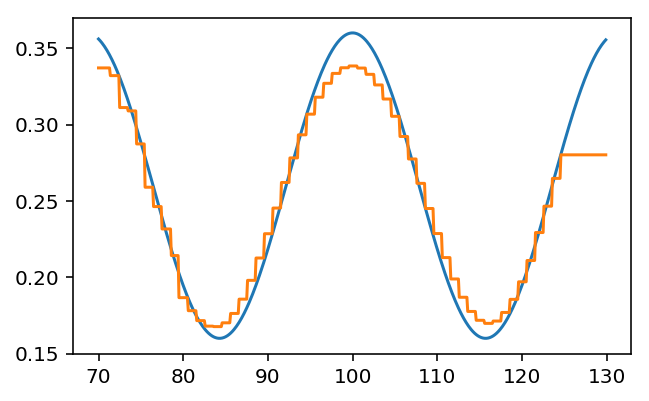

In [303]:
sv2.plot_fit(0)

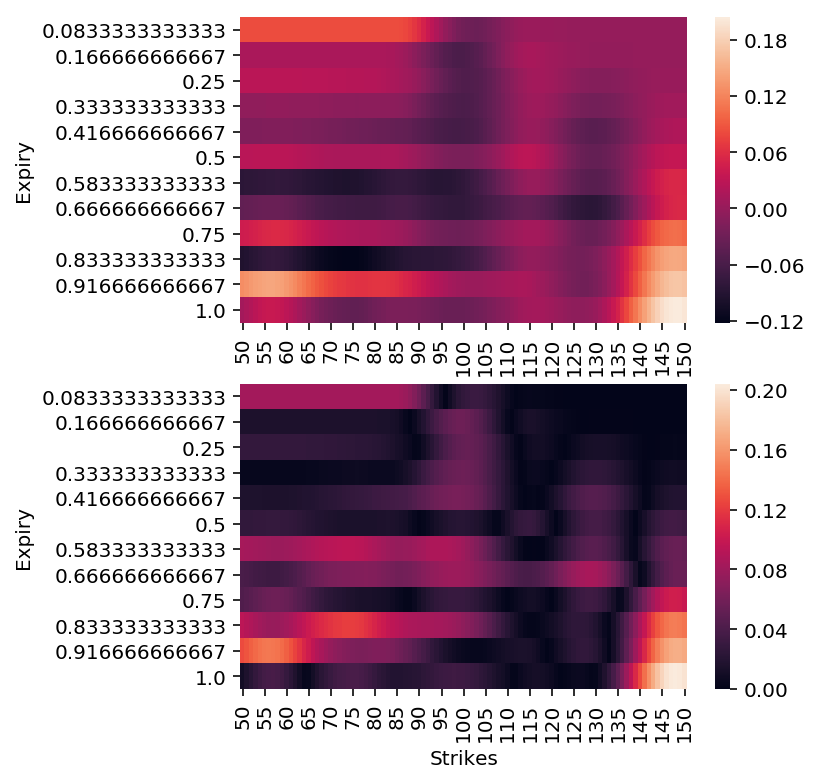

In [304]:
_ = sv.generate_prediction(n_samples=int(1e5))
sv.plot_errors()

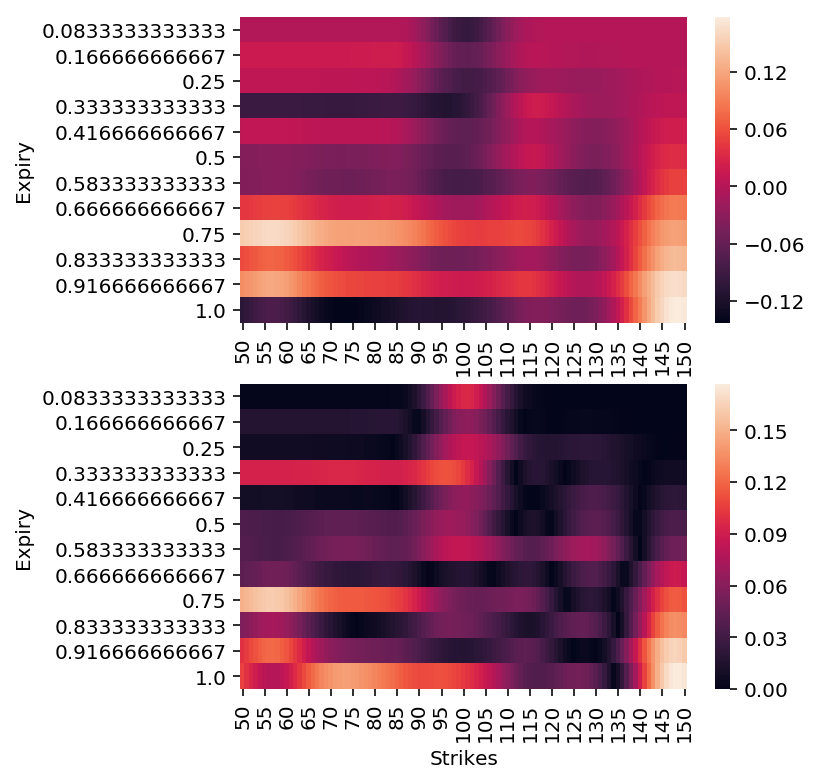

In [305]:
_ = sv2.generate_prediction(n_samples=int(1e5))
sv2.plot_errors()

# Logistic

In [185]:
def logistic_vol(px,time):
    return .24 + .1 / (1+np.exp((px-100)/5))
logisv = LocalVolatilityPricer(logistic_vol, expiries, K)
_ = logisv.get_true_prices(n_samples=int(1e5))

A Jupyter Widget

In [306]:
logisv2 = copy(logisv)

In [307]:
_ = logisv.fit_local_vol(fd_fitter, interp_option='nn', tol=0.005).dropna(axis=1)
_ = logisv2.fit_local_vol(local_quadratic_reg_fit, interp_option='nn', tol=0.005).dropna(axis=1)

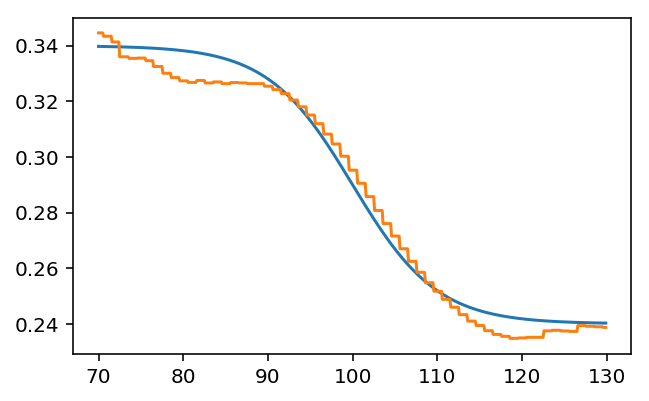

In [311]:
logisv.plot_fit(0)

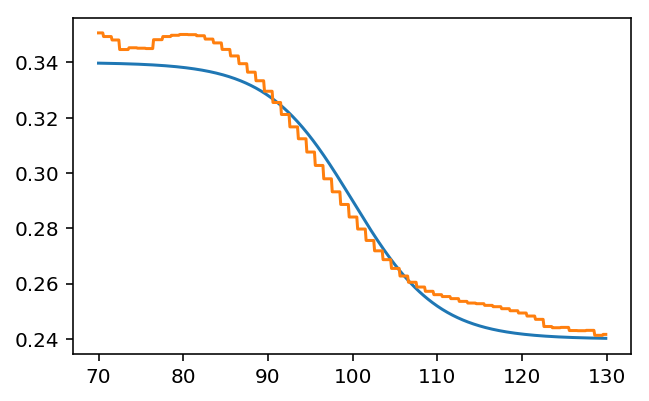

In [309]:
logisv2.plot_fit(0)

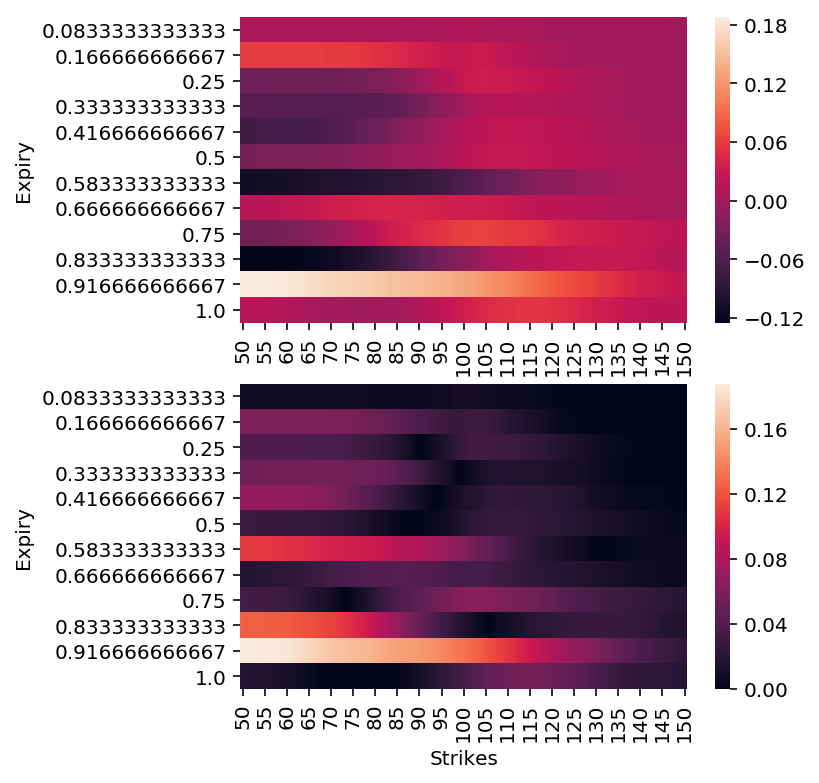

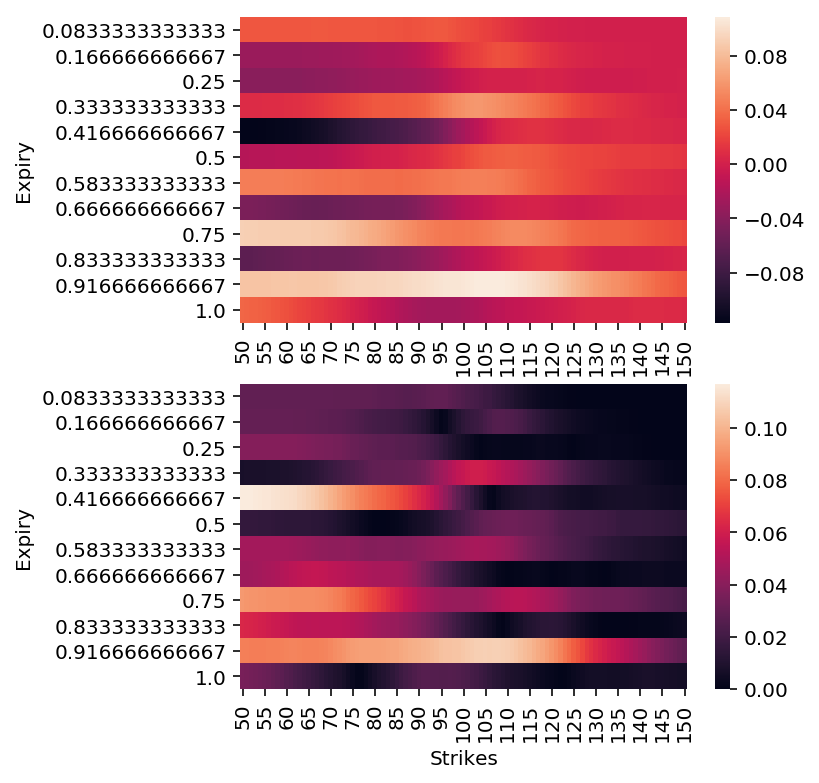

In [312]:
_ = logisv.generate_prediction(n_samples=int(1e5))
logisv.plot_errors()
_ = logisv2.generate_prediction(n_samples=int(1e5))
logisv2.plot_errors()

# Linear

In [316]:
def linear_vol(px, time):
    return np.clip(0.16 + (px - 100)/300,0,1)
linv = LocalVolatilityPricer(linear_vol, expiries, K)
_ = linv.get_true_prices(n_samples=int(1e5))

A Jupyter Widget

Exception in thread Thread-67:
Traceback (most recent call last):
  File "/Users/jiafengchen/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/jiafengchen/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/jiafengchen/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [317]:
linv2 = copy(linv)

In [318]:
_ = linv.fit_local_vol(fd_fitter, interp_option='nn', tol=0.005).dropna(axis=1)
_ = linv2.fit_local_vol(local_quadratic_reg_fit, interp_option='nn', tol=0.005).dropna(axis=1)

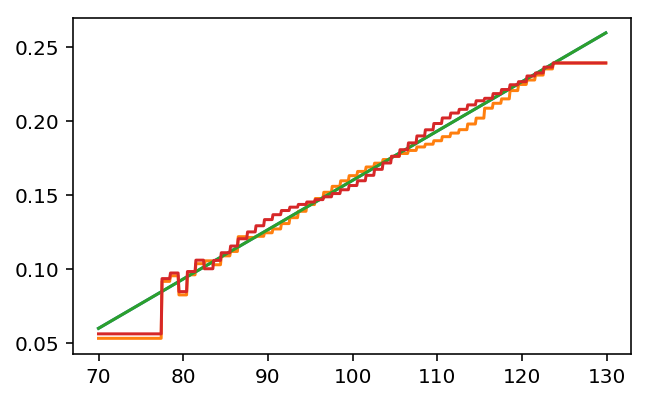

In [319]:
linv.plot_fit(0)
linv2.plot_fit(0)

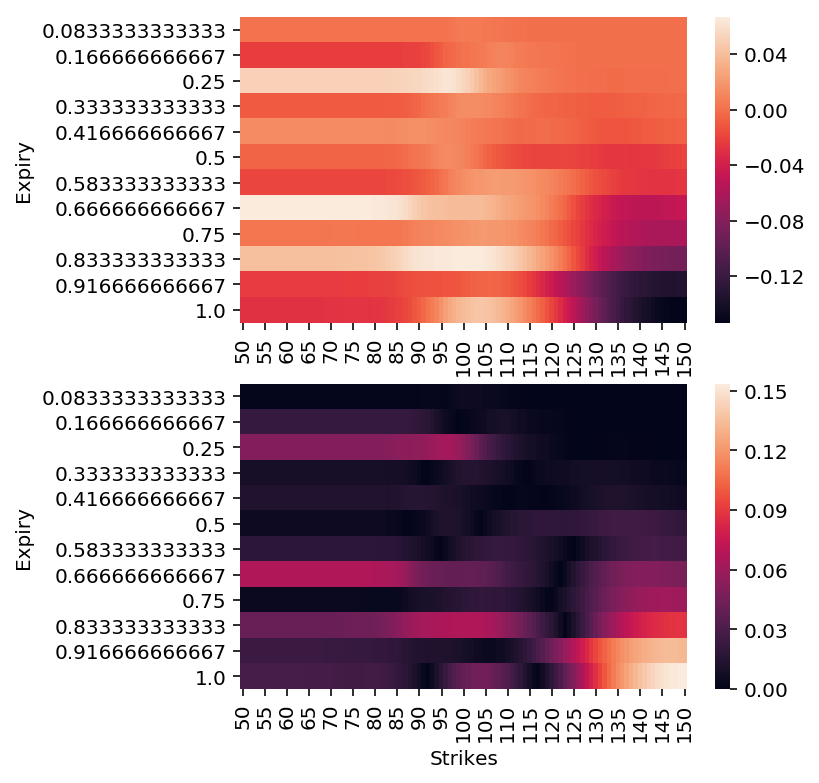

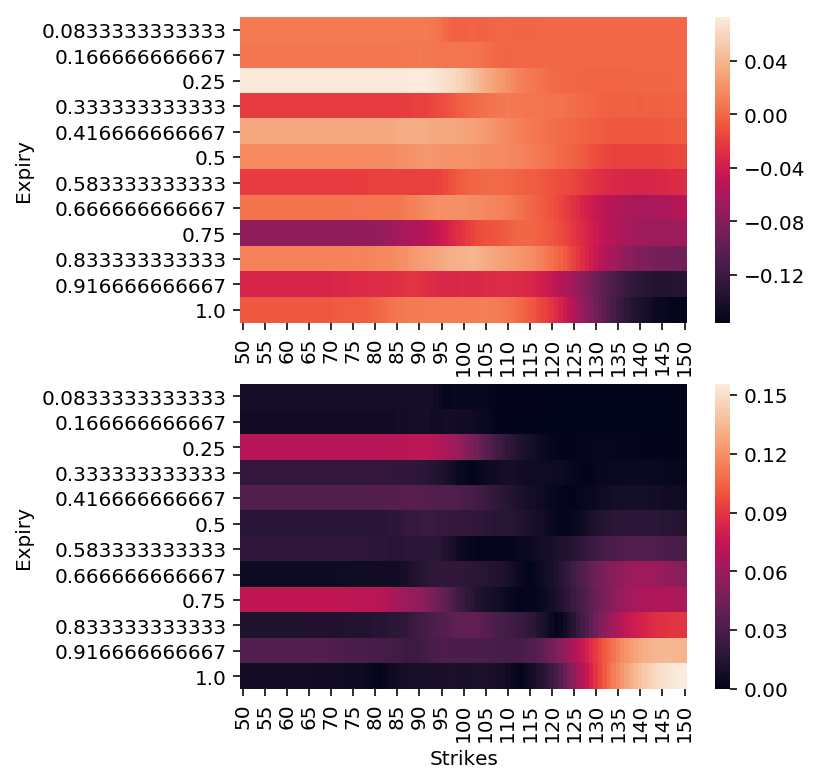

In [320]:
_ = linv.generate_prediction(n_samples=int(1e5))
linv.plot_errors()
_ = linv2.generate_prediction(n_samples=int(1e5))
linv2.plot_errors()

In [ ]:
def quadratic_vol_time(px, time):
    return np.clip(.16 + 1e-4*(px + 10 * time - 100)**2, 0, .5)

In [ ]:
qtv = LocalVolatilityPricer(quadratic_vol_time, expiries, K)
_ = qtv.get_true_prices(n_samples=int(1e5))

A Jupyter Widget

In [266]:
_ = qtv.fit_local_vol(fd_fitter, interp_option='nn', tol=0.01)

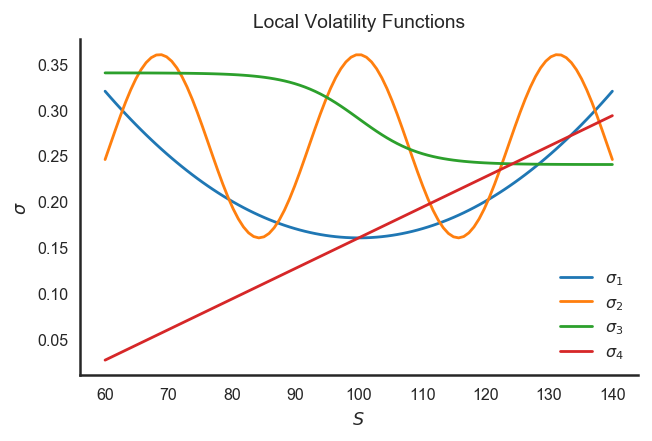

In [331]:
sns.set_style('white')
sns.set_context('paper')

xs = np.linspace(60, 140, 100)
plt.plot(xs, quadratic_vol(xs, 0), label='$\sigma_1$')
plt.plot(xs, sinusoidal_vol(xs, 0), label='$\sigma_2$')
plt.plot(xs, logistic_vol(xs, 0), label='$\sigma_3$')
plt.plot(xs, linear_vol(xs, 0), label='$\sigma_4$')
plt.legend()
plt.xlabel('$S$')
plt.ylabel('$\sigma$')
plt.title('Local Volatility Functions')
sns.despine()

plt.savefig('report/figs/local_vols.eps')

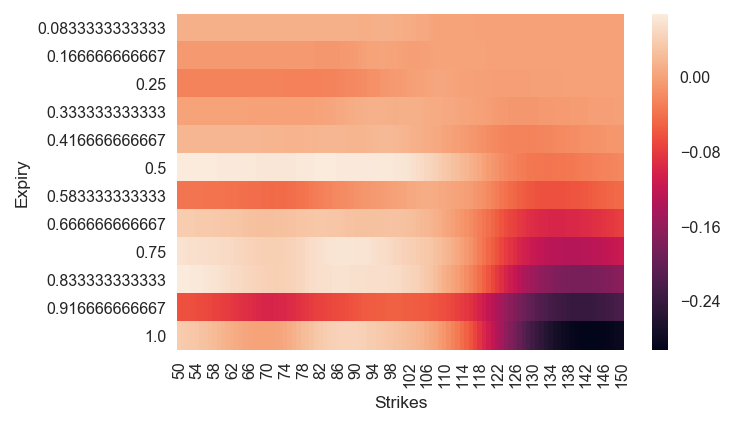

In [337]:
axs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22b47940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a22ad8828>]], dtype=object)

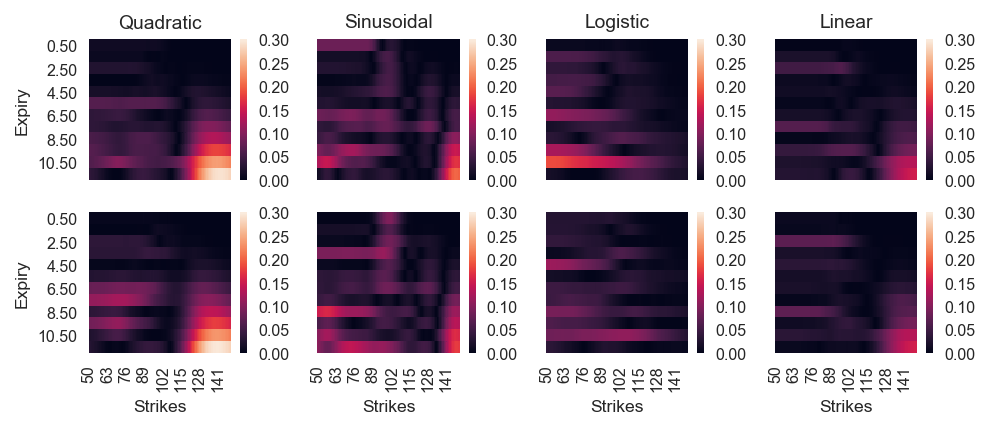

In [361]:
from matplotlib.ticker import FormatStrFormatter
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(7,5/1.618))
sns.heatmap(np.abs(qv.predicted_prices - qv.true_prices), ax=axs[0,0], vmin=0, vmax=0.3)
sns.heatmap(np.abs(qv2.predicted_prices - qv2.true_prices), ax=axs[1,0], vmin=0, vmax=0.3)
sns.heatmap(np.abs(sv.predicted_prices - sv.true_prices), ax=axs[0,1], vmin=0, vmax=0.3)
sns.heatmap(np.abs(sv2.predicted_prices - sv2.true_prices), ax=axs[1,1], vmin=0, vmax=0.3)
sns.heatmap(np.abs(logisv.predicted_prices - logisv.true_prices), ax=axs[0,2], vmin=0, vmax=0.3)
sns.heatmap(np.abs(logisv2.predicted_prices - logisv2.true_prices), ax=axs[1,2], vmin=0, vmax=0.3)
sns.heatmap(np.abs(linv.predicted_prices - linv.true_prices), ax=axs[0,3], vmin=0, vmax=0.3)
sns.heatmap(np.abs(linv2.predicted_prices - linv2.true_prices), ax=axs[1,3], vmin=0, vmax=0.3)
for ax in axs.flatten():
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
for ax in axs[:,1:].flatten():
    ax.yaxis.set_ticks([])
    ax.set_ylabel('')
for ax in axs[:-1,:].flatten():
    ax.xaxis.set_ticks([])
    ax.set_xlabel('')

title = ['Quadratic', 'Sinusoidal', 'Logistic', 'Linear']
for i, ax in enumerate(axs[0,:].flatten()):
    ax.set_title(title[i])
    
plt.tight_layout()

plt.savefig('report/figs/errors.eps')

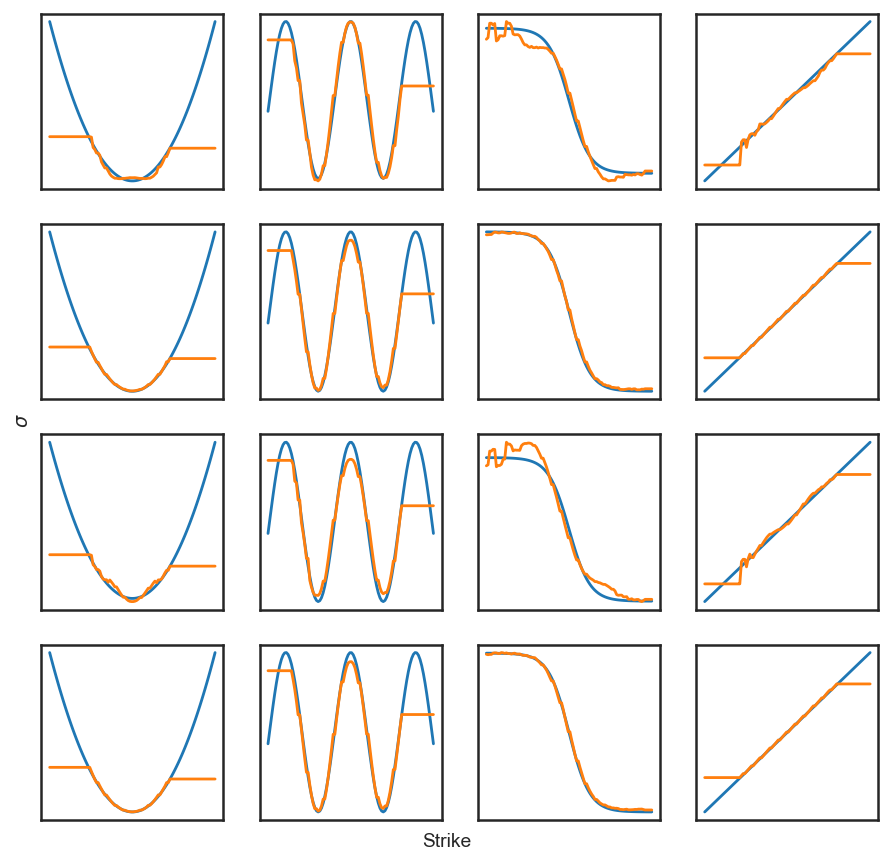

In [383]:
fig, axs = plt.subplots(sharex=True, sharey=False, nrows=4, ncols=4, figsize=(7.5,12/1.618))
xs = np.linspace(60,140,100)

axs[0,0].plot(quadratic_vol(xs, 0))
axs[0,0].plot(qv.interp_fitted_local_vol(xs, 0))
axs[1,0].plot(quadratic_vol(xs, 1))
axs[1,0].plot(qv.interp_fitted_local_vol(xs, 1))
axs[2,0].plot(quadratic_vol(xs, 0))
axs[2,0].plot(qv2.interp_fitted_local_vol(xs, 0))
axs[3,0].plot(quadratic_vol(xs, 1))
axs[3,0].plot(qv2.interp_fitted_local_vol(xs, 1))

axs[0,1].plot(sinusoidal_vol(xs, 0))
axs[0,1].plot(sv.interp_fitted_local_vol(xs, 0))
axs[1,1].plot(sinusoidal_vol(xs, 1))
axs[1,1].plot(sv.interp_fitted_local_vol(xs, 1))
axs[2,1].plot(sinusoidal_vol(xs, 0))
axs[2,1].plot(sv2.interp_fitted_local_vol(xs, 0))
axs[3,1].plot(sinusoidal_vol(xs, 1))
axs[3,1].plot(sv2.interp_fitted_local_vol(xs, 1))

axs[0,2].plot(logistic_vol(xs, 0))
axs[0,2].plot(logisv.interp_fitted_local_vol(xs, 0))
axs[1,2].plot(logistic_vol(xs, 1))
axs[1,2].plot(logisv.interp_fitted_local_vol(xs, 1))
axs[2,2].plot(logistic_vol(xs, 0))
axs[2,2].plot(logisv2.interp_fitted_local_vol(xs, 0))
axs[3,2].plot(logistic_vol(xs, 1))
axs[3,2].plot(logisv2.interp_fitted_local_vol(xs, 1))

axs[0,3].plot(linear_vol(xs, 0))
axs[0,3].plot(linv.interp_fitted_local_vol(xs, 0))
axs[1,3].plot(linear_vol(xs, 1))
axs[1,3].plot(linv.interp_fitted_local_vol(xs, 1))
axs[2,3].plot(linear_vol(xs, 0))
axs[2,3].plot(linv2.interp_fitted_local_vol(xs, 0))
axs[3,3].plot(linear_vol(xs, 1))
axs[3,3].plot(linv2.interp_fitted_local_vol(xs, 1))

for ax in axs.flatten():
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])


fig.text(0.5,0.1,'Strike',ha='center')
fig.text(0.1,0.5,'$\sigma$', va='center',rotation='vertical')
plt.savefig('report/figs/fits.eps')

(0.15, 0.18)

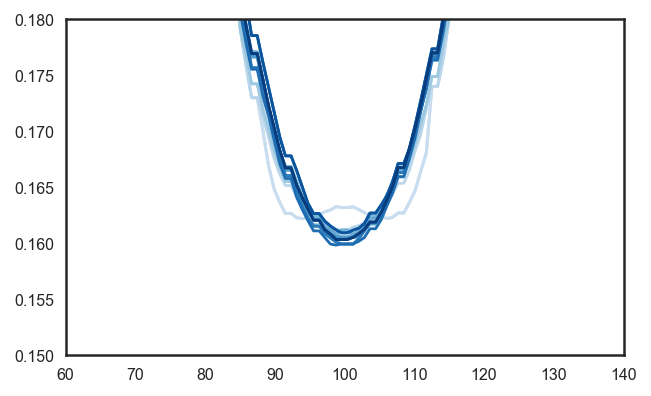

In [394]:
with sns.color_palette('Blues', len(np.arange(0,1,0.05))):
    for time in np.arange(0,1,0.05):
        xs = np.linspace(60,140,100)
        plt.plot(xs, qv.interp_fitted_local_vol(xs, time))
plt.xlim((60,140))
plt.ylim((0.15,0.18))